In [20]:
import time

In [21]:
from src import charts_utils
optionsCharts = charts_utils._setDefaultOptions()

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec

In [23]:
import nowcasting


In [24]:
sns.set_palette("husl", 20)

In [25]:
update = True
if update:
    nowcasting.main()
    time.sleep(5)

In [26]:
output_dict = pd.read_pickle('data/output_nowcast.pkl')
end_date = output_dict["end_date"]
print(end_date)

df_adj = output_dict["df_adj"]
weights = output_dict["weights"]
df_adj_future = output_dict["df_adj_future"]

2023-07-21


In [27]:
mapping_info = pd.read_excel(
        r'data/Nowcasting_input.xlsx', 
        sheet_name="main_input")
mapping_info = mapping_info.set_index(['Ticker'])

In [28]:
#mapping_info

In [29]:
aggregate_score = {}

for category in mapping_info.Group.unique():
    aggregate_score[category] = {}
    data_adj_cat = df_adj.loc[:, mapping_info.Group == category]#.dropna(axis=1)

    t = data_adj_cat.index[-1]    
     
    x = data_adj_cat.loc[:t, :]
    x = x.loc[:, ~x.iloc[-1,:].isna()]
    
    x_std = (x - x.mean()) / x.std()
    aggregate_score[category][t] = x_std @ weights[category][t]


(-2.0, 2.0)

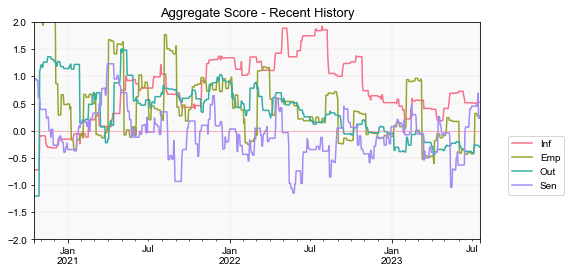

In [30]:
optionsCharts = charts_utils._setDefaultOptions()

score_now = pd.concat(
    [aggregate_score[i][t] for i in aggregate_score.keys()], 
    axis=1)
score_now.columns = aggregate_score.keys()
ax = score_now.iloc[-720:].dropna().plot(
    color=sns.color_palette("husl", 4),
    figsize=[8,4])
chartOptions = charts_utils._setDefaultOptions()
chartOptions["title"] = "Aggregate Score - Recent History"
chartOptions["legendPosition"] = None
chartOptions["legend_bbox_to_anchor"] = (1.05, 0.5)
charts_utils._axProperties(ax, chartOptions)
ax.axhline(0, linewidth=0.5,)
ax.set_ylim(-2,2)

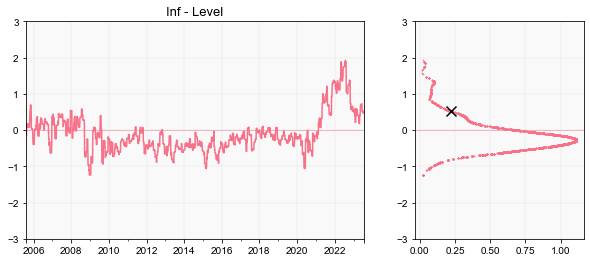

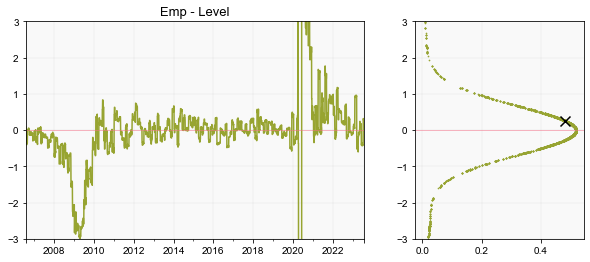

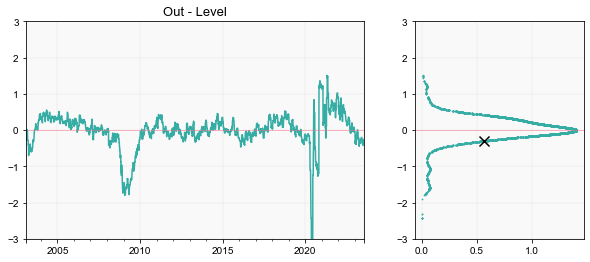

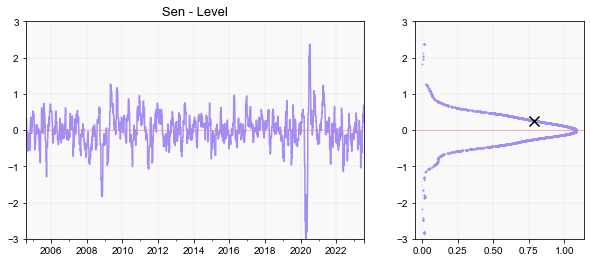

In [31]:
from scipy.stats import gaussian_kde

for i, j in enumerate(score_now.columns):
    x = score_now[j].dropna()
    kernel = gaussian_kde(x)
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
    fig = plt.figure(figsize=[10, 4])
    ax = fig.add_subplot(gs[0])
    x.plot(
        ax=ax,
        color=sns.color_palette("husl", 4)[i])
    chartOptions = charts_utils._setDefaultOptions()
    chartOptions["title"] = j + " - Level" 
    chartOptions["legendVisible"] = False
    charts_utils._axProperties(ax, chartOptions)
    ax.axhline(0, linewidth=0.5)
    ax.set_ylim([-3, 3])

    ax = fig.add_subplot(gs[1])
    ax.scatter(
        x=kernel(x),
        y=x,
        s=0.5,
        color=sns.color_palette("husl", 4)[i]
        )
    ax.scatter(
        x=kernel(x)[-1],
        y=x[-1],
        s=100,
        color="black",
        marker="x"
        )
    chartOptions = charts_utils._setDefaultOptions()
    chartOptions["title"] = ""
    chartOptions["legendVisible"] = False
    charts_utils._axProperties(ax, chartOptions)
    ax.axhline(0, linewidth=0.5)
    ax.set_ylim([-3, 3])
    

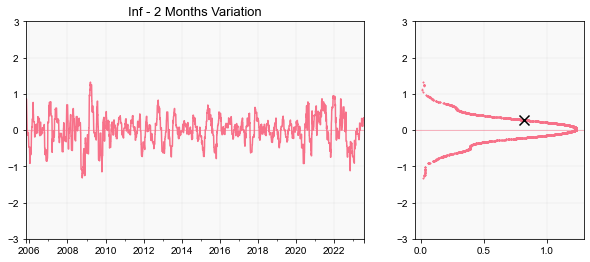

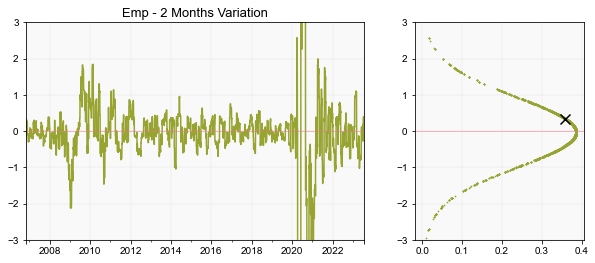

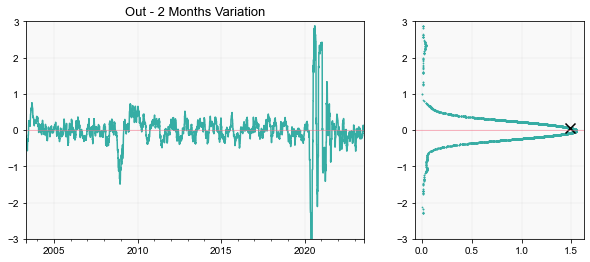

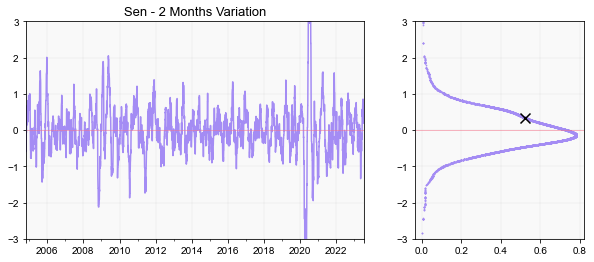

In [32]:
for i, j in enumerate(score_now.columns):
    x = score_now[j].diff(60).dropna()
    kernel = gaussian_kde(x)
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
    fig = plt.figure(figsize=[10, 4])
    ax = fig.add_subplot(gs[0])
    x.plot(
        ax=ax,
        color=sns.color_palette("husl", 4)[i])
    chartOptions = charts_utils._setDefaultOptions()
    chartOptions["title"] = j + " - 2 Months Variation" 
    chartOptions["legendVisible"] = False
    charts_utils._axProperties(ax, chartOptions)
    ax.axhline(0, linewidth=0.5)
    ax.set_ylim([-3, 3])

    ax = fig.add_subplot(gs[1])
    ax.scatter(
        x=kernel(x),
        y=x,
        s=0.5,
        color=sns.color_palette("husl", 4)[i]
        )
    ax.scatter(
        x=kernel(x)[-1],
        y=x[-1],
        s=100,
        color="black",
        marker="x"
        )
    chartOptions = charts_utils._setDefaultOptions()
    chartOptions["title"] = ""
    chartOptions["legendVisible"] = False
    charts_utils._axProperties(ax, chartOptions)
    ax.axhline(0, linewidth=0.5)
    ax.set_ylim([-3, 3])
    

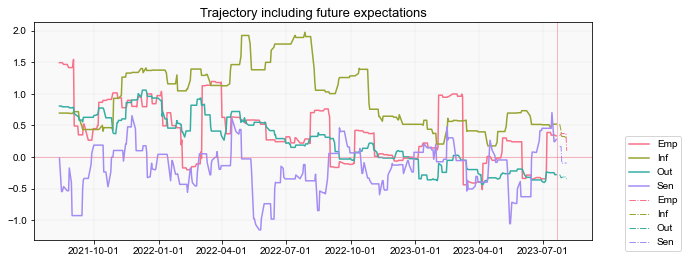

In [33]:
aggregate_score_future = {}
for category in mapping_info.Group.unique():

    df_adj_future_cat = df_adj_future.loc[:, mapping_info.Group == category]#.dropna(axis=1)    
    x = df_adj_future_cat.copy()
    x = x.loc[:, ~x.iloc[-1,:].isna()]
    
    x_std = (x - x.mean()) / x.std()
    x_std.index = x_std.index.date
    aggregate_score_future[category] = \
        x_std * weights[category][max(weights[category].keys())]
#%%

fig = plt.figure(figsize=[10, 4])
ax = fig.add_subplot(1, 1, 1)
df_plot = pd.concat(
    aggregate_score_future, axis=1
    ).groupby(level=0, axis=1).sum()
df_plot[:end_date].iloc[-360:, :].plot(ax=ax, color=sns.color_palette("husl", 4))
df_plot[end_date:].plot(
    ax=ax, 
    linestyle="-.", 
    linewidth=1, 
    color=[i.get_color() for i in ax.get_lines()],
    label=None)
chartOptions = charts_utils._setDefaultOptions()
chartOptions["legendPosition"] = None
chartOptions["legend_bbox_to_anchor"] = (1.05, 0.5)
chartOptions["title"] = "Trajectory including future expectations"

charts_utils._axProperties(ax, chartOptions)
ax.axvline(end_date, linewidth=0.5)
ax.axhline(0, linewidth=0.5)
ax.set_xticks(ax.get_xticks(), rotation=-90);

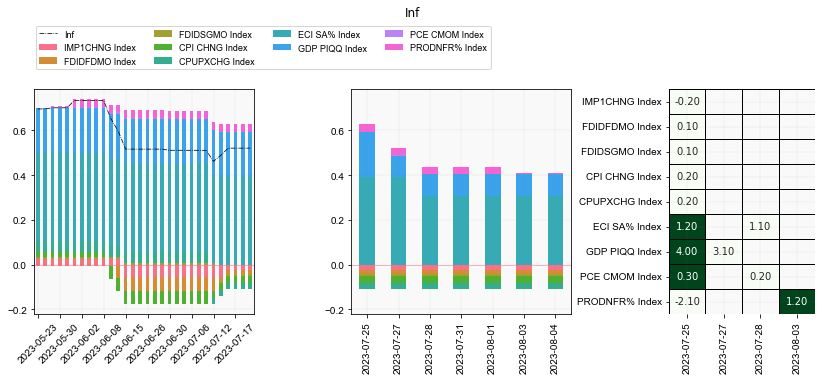

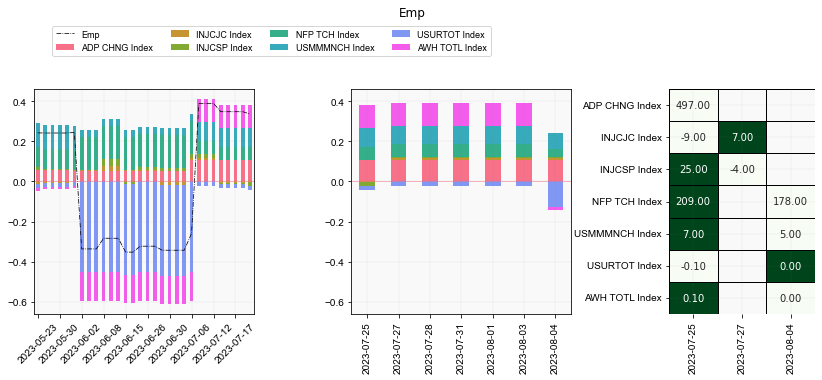

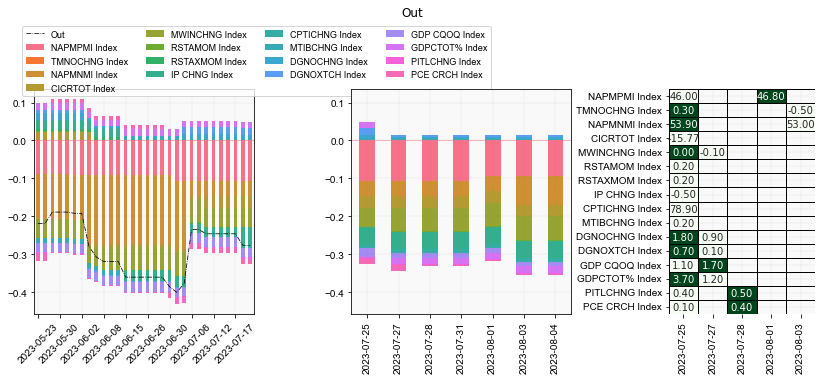

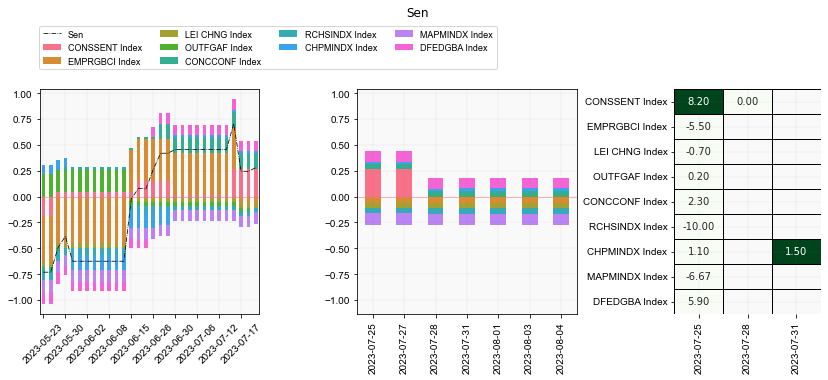

In [34]:
#%%
chartOptions['title'] = ""
for category in mapping_info.Group.unique():
    
    gs = gridspec.GridSpec(1, 3, width_ratios=[1.5, 1.5, 1], wspace=0.5, top=0.75)
    
    fig = plt.figure(figsize=[14, 5])
    fig.suptitle(
        category
        )
    ax = fig.add_subplot(gs[0])
    aggregate_score_future[category].loc[:end_date].iloc[-30:].plot.bar(
        ax=ax, 
        stacked=True, 
        color=sns.color_palette("husl", aggregate_score_future[category].shape[1]))
    aggregate_score_future[category].loc[:end_date].iloc[-30:].sum(axis=1).plot(
        ax=ax, color="black", linewidth=0.75, 
        linestyle="-.", use_index=False, 
        label=category)
    chartOptions['legendVisible'] = True
    chartOptions["legendPosition"] = None
    chartOptions["legend_bbox_to_anchor"] = (2, 0.9, 0.1, 0.4)
    chartOptions["legendNcol"] = 4
    chartOptions["legendFontSize"] = 9
    ax.axhline(0, linewidth=0.5)
    ax.set_xticks(ax.get_xticks()[::3])
    charts_utils._axProperties(ax, chartOptions)
    ax.tick_params(axis='x', rotation=45)
    
    ax2 = fig.add_subplot(gs[1])
    aggregate_score_future[category].loc[end_date:].plot.bar(
        ax=ax2, 
        stacked=True,
        legend=False,
        color=sns.color_palette("husl", aggregate_score_future[category].shape[1]))
    ax2.set_ylim(ax.get_ylim())
    ax2.axhline(0, linewidth=0.5) 
    chartOptions['legendVisible'] = False
    charts_utils._axProperties(ax2, chartOptions)
    
    ax3 = fig.add_subplot(gs[2])
    table_to_plot = df_adj_future.loc[
        end_date:, 
        mapping_info.Group == category].drop_duplicates().T
    table_to_plot = table_to_plot.loc[
        table_to_plot.isna().sum(axis=1) != table_to_plot.shape[1]]   
    
    table_to_plot[table_to_plot == table_to_plot.shift(1, axis=1)] = np.nan
    table_to_plot.columns = table_to_plot.columns.date
    
    sns.heatmap(
        data = table_to_plot.astype(float).rank(axis=1),
        annot = table_to_plot.astype(float),
        fmt='.2f',
        cbar=False,
        cmap='Greens',
        linecolor='k',
        linewidths=1,
        ax=ax3
        )
    charts_utils._axProperties(ax3, chartOptions)


In [35]:
mapping_info

,Unnamed: 0,Group,Index,First_diff,period_selection,api_structure
Ticker,,,,,,
IMP1CHNG Index,US Import Price Index by End Use All MoM 0 Rat...,Inf,Import Price Index by End Use All MoM,0,MONTHLY,1
FDIDFDMO Index,Inf US PPI Finished Goods Total MoM 0 Rate M B...,Inf,US PPI Finished Goods Total MoM,0,MONTHLY,1
FDIDSGMO Index,Inf US PPI Finished Goods Except Foods Energy ...,Inf,US PPI Finished Goods Except Foods Energy,0,MONTHLY,1
CPI CHNG Index,Inf US CPI Urban Consumers MoM 0 Rate M Bureau...,Inf,US CPI Urban Consumers MoM,0,MONTHLY,1
CPUPXCHG Index,Inf US CPI Urban Consumers Less Food Energy 0 ...,Inf,US CPI Urban Consumers Less Food Energy,0,MONTHLY,1
ECI SA% Index,Inf BLS Employment Cost Civilian Workers QoQ 0...,Inf,BLS Employment Cost Civilian Workers QoQ,0,QUARTERLY,1
GDP PIQQ Index,Inf US GDP Price Index QoQ SAAR 0 Rate Q Burea...,Inf,US GDP Price Index QoQ SAAR,0,QUARTERLY,2
PCE CMOM Index,Inf US Personal Cons. Expenditure Core Price I...,Inf,US Personal Cons. Expenditure Core Price Index...,0,MONTHLY,1
PRODNFR% Index,Inf US Output Per Hour Nonfarm Business Sector...,Inf,US Output Per Hour Nonfarm Business Sector QoQ,0,QUARTERLY,1
